Timothy Weigand
alejandra jaramillo
initial processing of epidermal data per vivosight manual: see vivosight manual for more information
1/24/25

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob

def collect_subject_id_from_folder(folder_in: str) -> str:
    """
    Determine the subject id from the input TEWL file name which has the format:

    """
    subject_id = folder_in.split("/")[-1].split("_")[0]
    return subject_id

def collect_subject_id_scan_information(file_in: str) -> str:
    """
    Determine the subject id from the input TEWL file name which has the format:

    """
    subject_id = file_in.split("/")[-1].split("_")[2]
    return subject_id


def collect_data_location(file_in: str) -> str:
    """
    Determine the subject id from the input TEWL file name which has the format:

    """
    location = file_in.split("/")[-1].split("_")[2]
    return location

def collect_scan_id(file_in: str) -> str:
    """
    Determine the subject id from the input TEWL file name which has the format:

    """
    scan_id = file_in.split("/")[-1].split("_")[3]
    if "L" in scan_id:
        scan_id = file_in.split("/")[-1].split("_")[4]
    return int(scan_id[1:])

def collect_arm_id_from_file(file_in: str) -> int:
    """
    
    """
    arm_id = file_in.split("/")[-1].split(".")[0].split("_")[1].split(" ")[0]
    
    return arm_id


class Scan:
    def __init__(self, scan_id, depth_data, summary_data, arm = None, location = None, post_exposure = None):
        self.scan_id = scan_id
        self.summary_data = summary_data
        self.depth_data = depth_data
        self.arm = arm
        self.location = location
        self.post_exposure = post_exposure

class Subject:
    def __init__(self, subject_id):
        self.subject_id = subject_id
        self.scans = None
        self.num_scans = 0

    def add_scan(self, scan_id, depth_data, summary_data, location, arm = None, post_exposure = None):
        """_summary_

        Args:
            visit_id (_type_): _description_
            return_visit (_type_): _description_
            data (_type_): _description_
        """
        if self.scans is None:
            self.scans = []

        self.scans.append(Scan(scan_id=scan_id, depth_data=depth_data, summary_data=summary_data, arm=arm, location=location, post_exposure=post_exposure))
        self.num_scans += 1

read in epidermal data

In [29]:
### Get a list of all files
vivosight_subject_data = glob.glob("../data/Vivosight_data/*")
print(vivosight_subject_data)

# initialize data
subject_ids = []
subject_data = {}

# Grab epidermal data for each subject
for folder in vivosight_subject_data:
    subject_id = collect_subject_id_from_folder(folder)

    if subject_id not in subject_data:
        subject_data[subject_id] = Subject(subject_id=subject_id)

    data_types_folders = glob.glob(folder+"/*") 
    for data_type_folder in data_types_folders:
        if "Epidermal" in data_type_folder:
            epidermal_data_files = glob.glob(data_type_folder+"/*.csv") 
            for epdiermal_data_file in epidermal_data_files:
                location = collect_data_location(epdiermal_data_file)
                scan_id = collect_scan_id(epdiermal_data_file)
                arm = collect_arm_id_from_file(epdiermal_data_file)
                
                # Read depth data
                try:
                    depth_data = pd.read_csv(epdiermal_data_file,header=6,encoding='latin1')
                except Exception as reason:
                    depth_data = None
                
                # Read summary data
                try:
                    summary_data = pd.read_csv(epdiermal_data_file,header=0,nrows=5, encoding='latin1')
                except Exception as reason:
                    summary_data = None
                
                subject_data[subject_id].add_scan(
                    scan_id=scan_id,
                    depth_data=depth_data, summary_data = summary_data, location=location
                )


['../data/Vivosight_data/A52_2_Results', '../data/Vivosight_data/W40_Results', '../data/Vivosight_data/M16_2_Results', '../data/Vivosight_data/F12_Results', '../data/Vivosight_data/L71_2_Results', '../data/Vivosight_data/B05_2_Results', '../data/Vivosight_data/P38_Results', '../data/Vivosight_data/B05_Results', '../data/Vivosight_data/U34_Results', '../data/Vivosight_data/R09_Results', '../data/Vivosight_data/U34_2_Results', '../data/Vivosight_data/N64_Results', '../data/Vivosight_data/L81_2_Results', '../data/Vivosight_data/L71_Results', '../data/Vivosight_data/C14_Results', '../data/Vivosight_data/E50_Results', '../data/Vivosight_data/Z47_Results', '../data/Vivosight_data/E11_Results', '../data/Vivosight_data/T98_Results', '../data/Vivosight_data/L81_Results', '../data/Vivosight_data/G07_2_Results', '../data/Vivosight_data/A52_Results', '../data/Vivosight_data/G07_Results', '../data/Vivosight_data/D47_Results', '../data/Vivosight_data/Y20_Results', '../data/Vivosight_data/R98_Results

In [30]:
### Get a list of all scan information files
scan_info_subject_data = glob.glob("../data/scan_information/*")

subject_info_data = {}

# Grab epidermal data for each subject
for file in scan_info_subject_data:
    subject_id = collect_subject_id_scan_information(file)
    print(subject_id)
    try:
        data_before_exp = pd.read_excel(file, 'Surface Area_AE')
        data_after_exp = pd.read_excel(file, 'Surface Area_BE')
    except Exception as reason:
        data_before_exp = None
        data_after_exp = None
        print(
                f"There is an issue with \t {file}. \t This data will be excluded from the analysis. Reason: {reason}"
            )

    # print(data_before_exp)    
    b_scan_id = data_before_exp["Scan#"].dropna()
    b_location = data_before_exp["Location"].dropna()

    a_scan_id = data_after_exp["Scan#"].dropna()
    a_location = data_after_exp["Location"].dropna()    

    if subject_id in subject_info_data:
        subject_info_data[subject_id]["before_scan_id"].extend(list(b_scan_id))
        subject_info_data[subject_id]["before_location"].extend(list(b_location))
        subject_info_data[subject_id]["after_scan_id"].extend(list(a_scan_id))
        subject_info_data[subject_id]["after_location"].extend(list(a_location))
    else:
        subject_info_data[subject_id] = {
            "before_scan_id":list(b_scan_id), 
            "before_location":list(b_location), 
            "after_scan_id": list(a_scan_id),
            "after_location":list(a_location)
            }


print(subject_info_data)

W40
B05
Z47
A52
Y20
G07
N64
B05
A52
L81
L81
R98
E11
P38
L71
S88
C14
F12
U34
M16
L71
D47
R09
R98
T98
U34
E50
G07
M16
{'W40': {'before_scan_id': [988.0, 989.0, 990.0, 991.0, 992.0, 993.0, 995.0, 997.0, 998.0, 999.0, 1000.0, 1001.0], 'before_location': [1249.0, 1249.0, 1249.0, 1250.0, 1250.0, 1250.0, 1251.0, 1251.0, 1251.0, 1252.0, 1252.0, 1252.0], 'after_scan_id': [974.0, 975.0, 976.0, 977.0, 978.0, 979.0, 981.0, 982.0, 983.0, 985.0, 986.0, 987.0], 'after_location': [1249.0, 1249.0, 1249.0, 1250.0, 1250.0, 1250.0, 1251.0, 1251.0, 1251.0, 1252.0, 1252.0, 1252.0]}, 'B05': {'before_scan_id': [1261.0, 1262.0, 1263.0, 1264.0, 1265.0, 1266.0, 1267.0, 1268.0, 1269.0, 1270.0, 1271.0, 1272.0, 1473.0, 1474.0, 1475.0, 1476.0, 1478.0, 1479.0, 1480.0, 1481.0, 1482.0, 1483.0, 1484.0, 1485.0], 'before_location': [1299.0, 1299.0, 1299.0, 1300.0, 1300.0, 1300.0, 1301.0, 1301.0, 1301.0, 1302.0, 1302.0, 1302.0, 1335.0, 1335.0, 1335.0, 1336.0, 1336.0, 1336.0, 1337.0, 1337.0, 1337.0, 1338.0, 1338.0, 1338.0],

In [ ]:
n = 0
for subject_id, subject in subject_data.items():
    if subject_id == "A52":
        for scan in subject.scans:

            exposed = None
            if scan.scan_id in subject_info_data[subject_id]['before_scan_id']:
                exposed = False
            elif scan.scan_id in subject_info_data[subject_id]['after_scan_id']:
                exposed = True

            fig, ax = plt.subplots()         
            plt.plot(
                scan.depth_data["Depth"],
                scan.depth_data["Mean A-scan"],
                label="Mean A-Scan",
            )
            # # plt.plot(
            #     scan.depth_data["Depth"],
            #     scan.depth_data["Fit Curve"],
            #     label="Fit Curve",

            # Compute the numerical derivative using central difference
            depth = np.array(scan.depth_data["Depth"])
            mean_ascan = np.array(scan.depth_data["Mean A-scan"])

            derivative_mean_ascan = np.gradient(mean_ascan, depth)

            # Plot the original graph
            fig, ax = plt.subplots()         
            plt.plot(depth, mean_ascan, label="Mean A-Scan")

            plt.plot(depth, derivative_mean_ascan, label="Derivative of Mean A-Scan", linestyle="dashed")

            plt.xticks(visible=False)
            if exposed:
                plt.title(f'Subject id: {subject_id}  Scan id: {scan.scan_id} Post-Exposure')
            else:
                plt.title(f'Subject id: {subject_id}  Scan id: {scan.scan_id} Pre-Exposure')
            plt.ylim(bottom=0)
            plt.ylabel("Intensity")
            plt.xlabel("Depth (mm)")
            plt.xlim(0,2)
            plt.legend() 
            plt.savefig(f"../data_out/epidermal_data_out/subject_id_{subject_id}_scan_id_{scan.scan_id}.pdf")
            plt.close()
            plt.show()


derivative practice

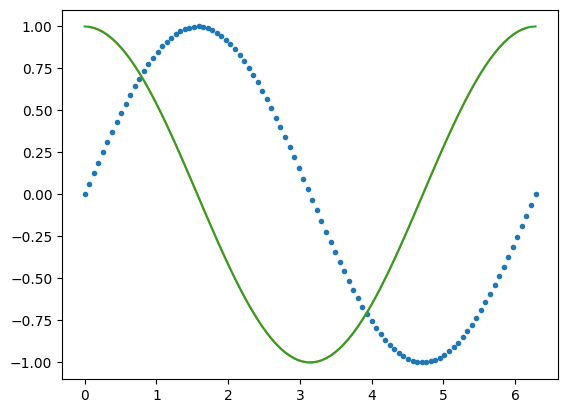

In [32]:
n_points = 100
locations = np.linspace(0,2*np.pi,n_points)
test_data = np.sin(locations)
derivative = np.zeros_like(test_data)

for n in range(1,n_points-1):
    derivative[n] = (test_data[n+1] - test_data[n-1])/(locations[n+1]- locations[n-1])

plt.plot(locations,test_data,'.')
plt.plot(locations[1:98],derivative[1:98])

# The derivative of sin is cos so a great check! 
plt.plot(locations,np.cos(locations))
plt.show()


# n_points = len(scan.depth_data["Mean A-scan"])
# locations = scan.depth_data["Depth"]
# test_data = scan.depth_data["Mean A-scan"]
# derivative = np.zero_like(test_data)

# for n in range(1, n_points-1):
#     derivative[n] = (test_data[n+1] - test_data[n-1])/(locations[n+1]- locations[n-1])

# plt.plot(locations, test_data, '.')
# plt.plot(locations[1:n_points-2], derivative[1:n_points-2])
# plt.show()

og plot code

In [ ]:

n = 0
for subject_id, subject in subject_data.items():
    if subject_id == "A52":
        for scan in subject.scans:

            exposed = None
            if scan.scan_id in subject_info_data[subject_id]['before_scan_id']:
                exposed = False
            elif scan.scan_id in subject_info_data[subject_id]['after_scan_id']:
                exposed = True

            fig, ax = plt.subplots()         
            plt.plot(
                scan.depth_data["Depth"],
                scan.depth_data["Mean A-scan"],
                label="Mean A-Scan",
            )
            plt.plot(
                scan.depth_data["Depth"],
                scan.depth_data["Fit Curve"],
                label="Fit Curve",
            )

            plt.xticks(visible=False)
            if exposed:
                plt.title(f'Subject id: {subject_id}  Scan id: {scan.scan_id} Post-Exposure')
            else:
                plt.title(f'Subject id: {subject_id}  Scan id: {scan.scan_id} Pre-Exposure')
            plt.ylim(bottom=0)
            plt.ylabel("Intensity")
            plt.xlabel("Depth (mm)")
            plt.xlim(0,2)
            plt.legend() 
            plt.savefig(f"../data_out/epidermal_data_out/subject_id_{subject_id}_scan_id_{scan.scan_id}.pdf")
            plt.close()
            plt.show()